In [1]:
#@title Imports
#%load_ext autoreload  #Need to uncomment for import sometime, dont understand

#Tensorflow :
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses
import tensorflow_datasets as tfds
#from google.colab import files

#Others :
from matplotlib import image
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rd
import cv2
import csv

#Data loaders :
from loadFer2013DS import *
from loadRavdessDS import *
from loadExpWDS import *
from loadAffwildDS import *

#Others
from utils import *
from config import *

Chargement du modèle...
Model used: exp903


In [2]:
#Chargement des données

# print("Array loading...")
# Xf = np.load("data/array/Xf.npy")
# Xe = np.load("data/array/Xe.npy")
# Xa = np.load("data/array/Xa.npy")
# Xr = np.load("data/array/Xr.npy")

# Yf = np.load("data/array/Yf.npy")
# Ye = np.load("data/array/Ye.npy")
# Ya = np.load("data/array/Ya.npy")
# Yr = np.load("data/array/Yr.npy")

# print("Concatenation...")
# X = np.concatenate([Xf, Xa, Xe, Xr])
# Y = np.concatenate([Yf, Xa, Xe, Yr])



# print("Array loading...")
# Xf = np.load("data/array/Xf.npy")
# Xe = np.load("data/array/Xe.npy")

# Yf = np.load("data/array/Yf.npy")
# Ye = np.load("data/array/Ye.npy")

# print("Concatenation...")
# X = np.concatenate([Xf, Xe])
# Y = np.concatenate([Yf, Ye])





# #Enregistre X et Y directement, à faire si assez de ram
# np.save("data/array/X", X)
# np.save("data/array/Y", Y)


#Chargment des données
X = np.load("data/array/X.npy")
Y = np.load("data/array/Y.npy")
print("X et Y chargés")

print("Done")

X et Y chargés
Done


In [5]:

#Chargment des données
X = np.load("data/array/X.npy")
Y = np.load("data/array/Y.npy")
print("X et Y chargés")

X et Y chargés


In [2]:
def loadData():
    return np.load("data/array/X.npy"), np.load("data/array/Y.npy")
X, Y = loadData()

In [ ]:
#@title Visualisation de chaque dataset
for X_, Y_, name in zip([Xf, Xr, Xe, Xa], [Yf, Yr, Ye, Ya], ["fer2013", "ravdess", "expW", "affwild"]):
    N=5
    M=5
    print("Dataset:", name)
    print("Images:", X_.shape, "Labels:", Y_.shape)
    plt.figure()
    for i in range(N*M):
        if X_.shape[0] == 0: continue
        k = rd.randrange(X_.shape[0])
        plt.subplot(N, M, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        afficher(X_[k])
        plt.title(emotions[int(Y_[k])])
    plt.show()

X: (125887, 48, 48, 1)
Y: (125887,)


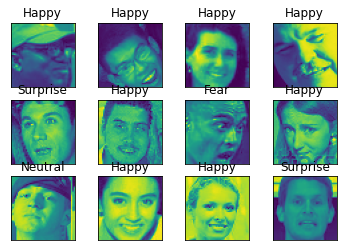

In [3]:
#Visualisation du dataset global
print("X:", X.shape)
print("Y:", Y.shape)

N=3
M=4
plt.figure()
for i in range(N*M):
    k = rd.randrange(X.shape[0])
    plt.subplot(N, M, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    afficher(X[k])
    plt.title(emotions[int(Y[k])])
plt.show()

dico créé
Angry, 8609 images, exemple:
Disgust, 4522 images, exemple:
Fear, 6185 images, exemple:
Happy, 39296 images, exemple:
Sad, 16609 images, exemple:
Surprise, 9854 images, exemple:
Neutral, 40812 images, exemple:
[8609, 4522, 6185, 39296, 16609, 9854, 40812]


<BarContainer object of 7 artists>

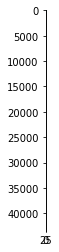

In [12]:
#Visualisation emotion par emotion
dicoEmotion = {emotion:[] for emotion in emotions}
for k in range(len(X)):
    emotion = emotions[int(Y[k])]
    dicoEmotion[emotion].append(k)
print("dico créé")
#print(dicoEmotion)

for emotion in dicoEmotion:
    print(f"{emotion}, {len(dicoEmotion[emotion])} images, exemple:")
    try:
        label = rd.choice(dicoEmotion[emotion])
        afficher(X[int(label)])
    except:
        pass
print([len(dicoEmotion[emotion]) for emotion in dicoEmotion])
plt.bar(range(7), [len(dicoEmotion[emotion]) for emotion in dicoEmotion])

In [4]:
#@title Hyperparamètres
epochs = 2
batch_size = 128
validation_size = 0.1

In [5]:
#Labels catégoriques
Ycat = keras.utils.to_categorical(Y)

print("X", X.shape)
print("Y", Ycat.shape)

X (125887, 48, 48, 1)
Y (125887, 7)


In [8]:
#MODELE
class MyModel(keras.Sequential):

    def __init__(self, input_shape):
        super(MyModel, self).__init__()
        #Pre processing
        self.add(keras.layers.experimental.preprocessing.RandomContrast(factor=(0.5,0.5)))
        self.add(keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"))
        
        #48*48 *1
        self.add(keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape))        
        self.add(keras.layers.MaxPooling2D(pool_size = 2))
        self.add(keras.layers.BatchNormalization())

        #23*23 *32
        self.add(keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
        self.add(keras.layers.MaxPooling2D(pool_size = 2))
        self.add(keras.layers.BatchNormalization())

        #10*10 *64
        self.add(keras.layers.Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
        self.add(keras.layers.MaxPooling2D(pool_size = 2))
        self.add(keras.layers.BatchNormalization())

        #4*4 *128
        self.add(keras.layers.Conv2D(256, kernel_size = (3, 3), activation = 'relu'))
        self.add(keras.layers.MaxPooling2D(pool_size = 2))
        self.add(keras.layers.BatchNormalization())
        
        #1*1 *256
        self.add(keras.layers.Flatten())
        self.add(keras.layers.Dense(256, activation = 'relu'))
        self.add(keras.layers.Dense(128, activation = 'relu'))
        self.add(keras.layers.Dense(64,  activation = 'relu'))
        self.add(keras.layers.Dense(20,  activation = 'relu'))
        self.add(keras.layers.Dense(7, activation = 'softmax'))
        #7        

        #Compile
        self.compile(optimizer = 'adam', loss=losses.categorical_crossentropy, metrics = ['accuracy'])

    
    def predir(self, monImage):
        return self.predict(np.array([monImage]))[0,:]

myModel = MyModel(input_shape)
#myModel.summary()

tf.Tensor(
[0.14272237 0.14253289 0.14222175 0.13957562 0.14415951 0.14358862
 0.14519916], shape=(7,), dtype=float32)


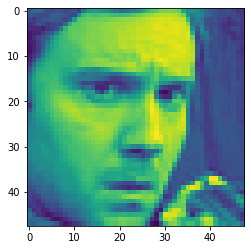

In [28]:
theImage = X[0]
afficher(theImage)
print(predir(myModel, theImage))

Epoch 1/5
935/935 [==============================] - 117s 124ms/step - loss: 1.2981 - accuracy: 0.5278 - val_loss: 1.0284 - val_accuracy: 0.6559
Epoch 2/5
935/935 [==============================] - 113s 121ms/step - loss: 1.1026 - accuracy: 0.6055 - val_loss: 1.0460 - val_accuracy: 0.6426
Epoch 3/5
935/935 [==============================] - 112s 120ms/step - loss: 1.0359 - accuracy: 0.6284 - val_loss: 1.0453 - val_accuracy: 0.6321
Epoch 4/5
935/935 [==============================] - 113s 121ms/step - loss: 0.9919 - accuracy: 0.6447 - val_loss: 1.0190 - val_accuracy: 0.6537
Epoch 5/5
935/935 [==============================] - 113s 121ms/step - loss: 0.9512 - accuracy: 0.6589 - val_loss: 1.0040 - val_accuracy: 0.6408


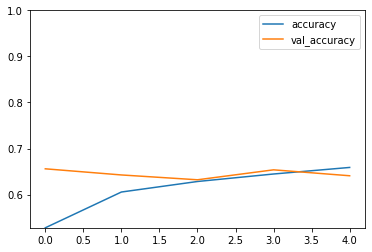

In [29]:
history = myModel.fit(X, Ycat, epochs=5, batch_size=128, validation_split=0.05)

#Affichage de l'historique de l'apprentissage
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.ylim([min(history.history['val_accuracy']+history.history['accuracy']), 1])
plt.show()

In [24]:
modelName = "exp908"
myModel.save(modelName)

INFO:tensorflow:Assets written to: exp907\assets


In [26]:
monModele = keras.models.load_model("models/"+modelName)
#monModele.summary()
monModele.fit(X[:10000], Ycat[:10000], validation_split = 0.9)

32/32 [==============================] - 5s 128ms/step - loss: 0.8691 - accuracy: 0.6737 - val_loss: 0.8754 - val_accuracy: 0.6761


In [30]:
print("Chargement du modèle...")
modelCM = keras.models.load_model('models/'+modelName)

print("Predictions...")
Nmax = 10000
y_pred = modelCM(X[:Nmax])
y_true = np.array([int(nbr) for nbr in Y[:Nmax]])

y_pred = np.argmax(y_pred, axis=-1)

print("Calcul de la CM...")
cm = confusion_matrix(y_true, y_pred)

print("Affichage...")
def show_confusion_matrix(matrix, labels):
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(matrix)
    
    N = len(labels)

    # We want to show all ticks...
    ax.set_xticks(np.arange(N))
    ax.set_yticks(np.arange(N))
    # ... and label them with the respective list entries
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(N):
        for j in range(N):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Matrice de confusion")
    fig.tight_layout()
    plt.show()
show_confusion_matrix(cm, emotions)

Chargement du modèle...
Predictions...
